# Project 2 - Ames Housing Data and Kaggle Challenge 
## Notebook 4/4: Modeling and Predictions

#### Kristina Joos
 
Notebook 1: Cleaning and Modfications of Train Data.  
Notebook 2: Cleaning and Modfications of Test Data.  
Notebook 3: Creation of the Null Treatment Data Frame.  
Notebook 4: Modeling and Predictions.  


## 4. Modeling 

### 4.1 Importing libraries
---

In [883]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
import sklearn.linear_model as linear_model
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import LassoCV
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import ElasticNetCV

%matplotlib inline

### 4.2 Loading the Cleaned and Modified Train Data
---

The Train Data was cleaned and modified in Notebook 1.
The Test Data was treated in the same way than the Train Data in Notebook 2.
Notebook 3 contains the creation of the Null Treatment Data Frame.

In [884]:
train_df_dummies = pd.read_csv("../data/train_df_dummies.csv")
test_df_dummies = pd.read_csv("../data/test_df_dummies.csv", index_col=[0])

In [885]:
train_df_dummies.columns

Index(['id', 'pid', 'ms_subclass', 'ms_zoning', 'lot_frontage', 'lot_area',
       'street', 'alley', 'lot_shape', 'land_contour',
       ...
       'garage_type_BuiltIn', 'garage_type_CarPort', 'garage_type_Detchd',
       'garage_type_none', 'utilities_NoSeWa', 'utilities_NoSewr',
       'total_liv_sqft', 'total_bsmt_1st_flr_sf', 'garage_total',
       'saleprice_log'],
      dtype='object', length=136)

In [886]:
test_df_dummies.columns

Index(['id', 'pid', 'ms_subclass', 'ms_zoning', 'lot_frontage', 'lot_area',
       'street', 'alley', 'lot_shape', 'land_contour',
       ...
       'garage_type_Attchd', 'garage_type_Basment', 'garage_type_BuiltIn',
       'garage_type_CarPort', 'garage_type_Detchd', 'garage_type_none',
       'utilities_NoSewr', 'total_liv_sqft', 'total_bsmt_1st_flr_sf',
       'garage_total'],
      dtype='object', length=130)

### 4.3 Custom Class
___

In [887]:
class CustomLinreg:
   
    def __init__(self, model_name, model_number):
        
        self.model_name = model_name
        self.model_number = model_number
        
        
        
    def make_model (self, features, train_df = train_df_dummies ): # Code adapted from Cameron Bronstein.
    
        self.features = features
        self.train_df = train_df
        X = self.train_df[self.features]
        y = train_df_dummies['saleprice_log']

        # train test split:
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(X, y, 
                                                        random_state = 13)

        self.model_name= LinearRegression()
        self.model_name.fit(self.X_train, self.y_train)
        
        
        predict_y = self.model_name.predict(self.X_test)
       
        model_evaluation = pd.DataFrame({'Train R2 score':self.model_name.score(self.X_train, self.y_train),'Cross val R2 score':cross_val_score(self.model_name,self.X_train, self.y_train, cv=5).mean(),'Test R2 score': self.model_name.score(self.X_test, self.y_test),'Mean Squared Error':mean_squared_error(self.y_test, predict_y)}, index=[f'Model_{self.model_number}'])
        
        print(model_evaluation)
    
        model_evaluation.to_csv(f'../data/model_evaluation_model_{self.model_number}', index=False)
        
        model_features = pd.Series(self.model_name.coef_, index = self.train_df[self.features].columns)
        
        #plt.figure(figsize=(10,20))
        #model_features.plot(kind='barh')
        #plt.savefig('../data/OLS_figure.jpg')
        #plt.show();
        

        
  

    def make_predicition_submission(self,test_df): # Code adapted from Cameron Bronstein.
        
        self.test_df = test_df
        
        test_preds = self.model_name.predict(self.test_df[self.features])
        test_preds_invers = np.exp(test_preds) #because sales price in the model is log
        

        self.test_df['preds'] = test_preds_invers

        submission = self.test_df.loc[:, ['id', 'preds']]

        submission.rename(columns = {'id': 'Id', 'preds': 'SalePrice'}, inplace=True)

        # Safe DF as csv for submission.
        submission.to_csv(f'../submissions/submission_{str(self.model_number)}', index=False)
    
    
    
    def make_OLS_params(self, OLS_name):
        
        self.OLS_name = OLS_name
        self.X_train = sm.add_constant(self.X_train)
        self.OLS_name = sm.OLS(self.y_train,self.X_train)
        results = self.OLS_name.fit()
        print(f'Parameters OLS {self.model_number}: {results.params}')
        print('------------------------------------------------------------------------------\n \n')
        print(f'Test score OLS {self.model_number}: {results.summary()}')
        
        
        
    def make_sc(self, features, sc_name, Z_test_name, Z_train_name, test_df, train_df = train_df_dummies):
        self.train_df = train_df
        self.features = features
        self.sc_name = sc_name
        self.Z_train_name = Z_train_name
        self.Z_test_name = Z_test_name
        self.test_df = test_df
        
        X_sc = self.train_df[features]
        y_sc = self.train_df['saleprice_log']

   
        self.X_sc_train, self.X_sc_test, self.y_sc_train, self.y_sc_test = train_test_split(X_sc, y_sc, 
                                                     random_state = 13)
        self.sc_name = StandardScaler()
        self.Z_train_name = self.sc_name.fit_transform(self.X_sc_train)
        self.Z_test_name =self.sc_name.transform(self.X_sc_test)
        self.test_df_sc = self.sc_name.transform(self.test_df[self.features])
        
    def make_poly_features(self, poly_features):
        
        self.poly_features = poly_features
        X_poly = train_df_dummies[self.poly_features]
        y_poly = train_df_dummies['saleprice_log']
        
        poly = PolynomialFeatures(include_bias=False)
        X_poly = poly.fit_transform(X_poly)
        poly.get_feature_names(self.poly_features)
        poly_df = pd.DataFrame(X_poly, columns = poly.get_feature_names(self.poly_features))
        poly_df['saleprice_log'] = train_df_dummies['saleprice_log']
        poly_df['id'] = train_df_dummies['id']
        print('Use poly_df for Standardization')
       
        
        
        
        
        
    def make_model_lasso(self): # Code adapted from Tim Book's lecture ' Introduction to Regularization'
        
        
        # Set up a list of Lasso alphas to check.
        alpha_1 = np.logspace(-3,0,100)
        # Cross-validate over our list of Lasso alphas.
        self.model_name = LassoCV(alphas=alpha_1, cv=5, max_iter=5000)
        # Fit.
        self.model_name.fit(self.Z_train_name, self.y_sc_train)
        
        predict_y = self.model_name.predict(self.Z_test_name)
       
        model_evaluation = pd.DataFrame({'Train R2 score':self.model_name.score(self.Z_train_name, self.y_sc_train),'Cross val R2 score':cross_val_score(self.model_name,self.Z_train_name, self.y_sc_train, cv=5).mean(),'Test R2 score': self.model_name.score(self.Z_test_name, self.y_sc_test),'Mean Squared Error':mean_squared_error(self.y_sc_test, predict_y)}, index=[f'Model_{self.model_number}'])
        
        print(model_evaluation)
    
        model_evaluation.to_csv(f'../data/model_evaluation_Model_{self.model_number}', index=False)
        
        # Adapted from Medium Post: Lasso, Ridge and Elastic Net Regularization by Jayesh Bapu Ahire
        model_features = pd.Series(self.model_name.coef_, index = self.train_df[self.features].columns)
        
        plt.figure(figsize=(10,20))
        model_features.plot(kind='barh')
        plt.savefig('../data/lasso.jpg')
        plt.show();

        
    def make_predicition_submission_sc(self): #make predictions and submission if data is standardized.
        
        test_preds = self.model_name.predict(self.test_df_sc)
        test_preds_invers = np.exp(test_preds) #because sales price in the model is log
        
        self.test_df['preds'] = test_preds_invers

        submission = self.test_df.loc[:, ['id', 'preds']]

        submission.rename(columns = {'id': 'Id', 'preds': 'SalePrice'}, inplace=True)

        # Safe DF as csv for submission.
        submission.to_csv(f'../submissions/submission_{str(self.model_number)}', index=False)
    
            
    def make_model_ridge(self):# Code adapted from Tim Book's lecture ' Introduction to Regularization'
        r_alphas = np.logspace(0, 5, 1000)

        self.model_name = RidgeCV(alphas=r_alphas, scoring="r2", cv=5)
        
        self.model_name.fit(self.Z_train_name, self.y_sc_train)
        
        predict_y = self.model_name.predict(self.Z_test_name)
       
        model_evaluation = pd.DataFrame({'Train R2 score':self.model_name.score(self.Z_train_name, self.y_sc_train),'Cross val R2 score':cross_val_score(self.model_name,self.Z_train_name, self.y_sc_train, cv=5).mean(),'Test R2 score': self.model_name.score(self.Z_test_name, self.y_sc_test),'Mean Squared Error':mean_squared_error(self.y_sc_test, predict_y)}, index=[f'Model_{self.model_number}'])
        
        print(model_evaluation)
    
        model_evaluation.to_csv(f'../data/model_evaluation_Model_{self.model_number}', index=False)
        
        model_features = pd.Series(self.model_name.coef_, index = self.train_df[self.features].columns)
        
        plt.figure(figsize=(10,20))
        model_features.plot(kind='barh')
        plt.savefig('../data/ridge.jpg')
        plt.show();

        
        
    def make_model_elastic_net(self):
  

        self.model_name = ElasticNetCV(cv=5, random_state = 13)
        
        self.model_name.fit(self.Z_train_name, self.y_sc_train)
        
        predict_y = self.model_name.predict(self.Z_test_name)
       
        model_evaluation = pd.DataFrame({'Train R2 score':self.model_name.score(self.Z_train_name, self.y_sc_train),'Cross val R2 score':cross_val_score(self.model_name,self.Z_train_name, self.y_sc_train, cv=5).mean(),'Test R2 score': self.model_name.score(self.Z_test_name, self.y_sc_test),'Mean Squared Error':mean_squared_error(self.y_sc_test, predict_y)}, index=[f'Model_{self.model_number}'])
        
        print(model_evaluation)
    
        model_evaluation.to_csv(f'../data/model_evaluation_Model_{self.model_number}', index=False)
        
        model_features = pd.Series(self.model_name.coef_, index = self.train_df[self.features].columns)
        
        plt.figure(figsize=(10,20))
        model_features.plot(kind='barh')
        plt.savefig('../data/elasticnet.jpg')
        plt.show();





### 4.3 Modeling and Predictions
___

__Model 1:__

In [888]:
model_1 = CustomLinreg('model_1', 1)

In [889]:
features_1 = ['overall_qual', 'total_liv_sqft', 'exter_qual',
       'kitchen_qual', 'garage_total', 'bsmt_qual', 'year_built',
       'year_remod/add', 'fireplace_qu', 'full_bath', 'totrms_abvgrd',
       'mas_vnr_area']


__Make model:__

In [890]:
model_1.make_model(features_1)

         Train R2 score  Cross val R2 score  Test R2 score  Mean Squared Error
Model_1        0.865167            0.863666       0.885843            0.018662


In [891]:
model_1.make_OLS_params('OLS_model_1')

Parameters OLS 1: const             3.216238
overall_qual      0.085481
total_liv_sqft    0.000131
exter_qual        0.000466
kitchen_qual      0.040136
garage_total      0.000038
bsmt_qual         0.006092
year_built        0.001867
year_remod/add    0.001912
fireplace_qu      0.015694
full_bath        -0.018118
totrms_abvgrd     0.003827
mas_vnr_area     -0.000033
dtype: float64
------------------------------------------------------------------------------
 

Test score OLS 1:                             OLS Regression Results                            
Dep. Variable:          saleprice_log   R-squared:                       0.865
Model:                            OLS   Adj. R-squared:                  0.864
Method:                 Least Squares   F-statistic:                     814.4
Date:                Thu, 03 Oct 2019   Prob (F-statistic):               0.00
Time:                        21:30:43   Log-Likelihood:                 717.82
No. Observations:                1536   AI

/Users/kristina/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


__Make Predictions and safe submission file:__

In [892]:
model_1.make_predicition_submission(test_df_dummies)

### Model 2

log transform total_liv_sqft and overall_qual.
___

In [893]:
# log transform for total_liv_sqft and overall_qual.

train_df_dummies['overall_qual_log']=train_df_dummies['overall_qual'].map(np.log)
train_df_dummies['total_liv_sqft_log']=train_df_dummies['total_liv_sqft'].map(np.log)

In [894]:
features_2 = ['overall_qual_log', 'total_liv_sqft_log',
       'kitchen_qual', 'garage_total', 'bsmt_qual', 'year_built',
       'year_remod/add', 'fireplace_qu','totrms_abvgrd',
       'mas_vnr_area', 'full_bath']

In [895]:
model_2 = CustomLinreg('model_2',2)

__Make model:__

In [896]:
model_2.make_model(features_2)

         Train R2 score  Cross val R2 score  Test R2 score  Mean Squared Error
Model_2        0.869792            0.864925       0.886628            0.018534


In [897]:
model_2.make_OLS_params('OLS_model_2')

Parameters OLS 2: const                -0.745303
overall_qual_log      0.438414
total_liv_sqft_log    0.554607
kitchen_qual          0.060015
garage_total          0.000063
bsmt_qual            -0.006501
year_built            0.001722
year_remod/add        0.001850
fireplace_qu          0.017936
totrms_abvgrd         0.003168
mas_vnr_area          0.000035
full_bath            -0.013251
dtype: float64
------------------------------------------------------------------------------
 

Test score OLS 2:                             OLS Regression Results                            
Dep. Variable:          saleprice_log   R-squared:                       0.870
Model:                            OLS   Adj. R-squared:                  0.869
Method:                 Least Squares   F-statistic:                     925.5
Date:                Thu, 03 Oct 2019   Prob (F-statistic):               0.00
Time:                        21:30:43   Log-Likelihood:                 744.63
No. Observations:    

/Users/kristina/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


__Load already modified test set:__

In [898]:
test_df_dummies_model_2 = pd.read_csv("../data/test_df_dummies_model_2.csv", index_col=[0])

In [899]:
test_df_dummies_model_2.columns

Index(['id', 'pid', 'ms_subclass', 'ms_zoning', 'lot_frontage', 'lot_area',
       'street', 'alley', 'lot_shape', 'land_contour',
       ...
       'garage_type_BuiltIn', 'garage_type_CarPort', 'garage_type_Detchd',
       'garage_type_none', 'utilities_NoSewr', 'total_liv_sqft',
       'total_bsmt_1st_flr_sf', 'garage_total', 'overall_qual_log',
       'total_liv_sqft_log'],
      dtype='object', length=132)

__Make Predictions and safe submission file:__

In [900]:
model_2.make_predicition_submission(test_df_dummies_model_2)

__Model 2 performed better that Model 1 when evaluated against the test set.__

### Model 3

Remove features from Model 2 that didn't impact the model: 'totrms_abvgrd',
       'mas_vnr_area'.
___

In [901]:
features_3 = ['overall_qual_log', 'total_liv_sqft_log',
       'kitchen_qual', 'garage_total', 'bsmt_qual', 'year_built',
       'year_remod/add', 'fireplace_qu','full_bath']


In [902]:
model_3=CustomLinreg('model_3',3)

In [903]:
model_3.make_model(features_3)

         Train R2 score  Cross val R2 score  Test R2 score  Mean Squared Error
Model_3        0.869559            0.865159       0.885696            0.018686


In [904]:
model_3.make_OLS_params('OLS_model_3')

Parameters OLS 3: const                -0.760751
overall_qual_log      0.440968
total_liv_sqft_log    0.567208
kitchen_qual          0.060552
garage_total          0.000065
bsmt_qual            -0.007575
year_built            0.001723
year_remod/add        0.001810
fireplace_qu          0.018270
full_bath            -0.011294
dtype: float64
------------------------------------------------------------------------------
 

Test score OLS 3:                             OLS Regression Results                            
Dep. Variable:          saleprice_log   R-squared:                       0.870
Model:                            OLS   Adj. R-squared:                  0.869
Method:                 Least Squares   F-statistic:                     1130.
Date:                Thu, 03 Oct 2019   Prob (F-statistic):               0.00
Time:                        21:30:43   Log-Likelihood:                 743.26
No. Observations:                1536   AIC:                            -1467.
Df R

/Users/kristina/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [905]:
model_3.make_predicition_submission(test_df_dummies_model_2)

__Model 3 performed worse that Model 2 when evaluated against the test set.__

### Model 4
Using Polynominal Features on features from Model 2
___

In [906]:
features_4= ['overall_qual_log', 'total_liv_sqft_log',
       'kitchen_qual', 'garage_total', 'bsmt_qual', 'year_built',
       'year_remod/add', 'fireplace_qu', 'totrms_abvgrd',
       'mas_vnr_area', 'full_bath']

In [907]:
model_4 = CustomLinreg('model_4',4)

In [908]:
model_4.make_poly_features(features_4)

Use poly_df for Standardization


In [909]:
poly_df

,overall_qual_log,total_liv_sqft_log,kitchen_qual,garage_total,bsmt_qual,year_built,year_remod/add,fireplace_qu,totrms_abvgrd,mas_vnr_area,...,fireplace_qu full_bath,totrms_abvgrd^2,totrms_abvgrd mas_vnr_area,totrms_abvgrd full_bath,mas_vnr_area^2,mas_vnr_area full_bath,full_bath^2,saleprice_log,preds,id
0,1.791759,8.346642,4.0,950.0,3.0,1976.0,2005.0,0.0,6.0,289.0,...,0.0,36.0,1734.0,12.0,83521.0,578.0,4.0,11.779129,173154.860691,109
1,1.945910,8.664578,4.0,1118.0,4.0,1996.0,1997.0,3.0,8.0,132.0,...,6.0,64.0,1056.0,16.0,17424.0,264.0,4.0,12.301383,238069.937679,544
2,1.609438,8.269245,4.0,246.0,3.0,1953.0,2007.0,0.0,5.0,0.0,...,0.0,25.0,0.0,5.0,0.0,0.0,1.0,11.599103,140759.154953,153
3,1.609438,8.093157,3.0,800.0,4.0,2006.0,2007.0,0.0,7.0,0.0,...,0.0,49.0,0.0,14.0,0.0,0.0,4.0,12.066811,135840.676904,318
4,1.791759,8.179200,3.0,968.0,2.0,1900.0,1993.0,0.0,6.0,0.0,...,0.0,36.0,0.0,12.0,0.0,0.0,4.0,11.838626,128484.777984,255
5,1.791759,8.619750,4.0,1156.0,3.0,1966.0,2002.0,4.0,6.0,0.0,...,8.0,36.0,0.0,12.0,0.0,0.0,4.0,12.154779,211964.947471,138
6,1.791759,8.082711,3.0,1050.0,4.0,2005.0,2006.0,0.0,5.0,82.0,...,0.0,25.0,410.0,10.0,6724.0,164.0,4.0,11.849398,147982.791146,2827
7,1.609438,8.425955,3.0,1062.0,3.0,1959.0,1959.0,0.0,6.0,180.0,...,0.0,36.0,1080.0,6.0,32400.0,180.0,1.0,11.863582,142339.548065,145
8,1.609438,8.027477,3.0,420.0,3.0,1952.0,1952.0,0.0,6.0,0.0,...,0.0,36.0,0.0,6.0,0.0,0.0,1.0,11.630709,106925.234855,1942
9,1.609438,8.674197,2.0,1008.0,4.0,1969.0,1969.0,3.0,9.0,192.0,...,3.0,81.0,1728.0,9.0,36864.0,192.0,1.0,11.813030,167204.788434,1956


In [910]:
model_4.make_sc(features_4, 'model_4_sc', 'Z_test_model_4','Z_train_model_4', poly_df)

In [911]:
model_4.make_model(features_4)

         Train R2 score  Cross val R2 score  Test R2 score  Mean Squared Error
Model_4        0.869792            0.864925       0.886628            0.018534


In [912]:
poly_df['id'] = train_df_dummies['id']


In [913]:
model_4.make_predicition_submission_sc()


#### Model 4 performed worse that Model 2 when evaluated against the test set

### Model 5
Using all features that have a correlation of more than 0.5 with saleprice_log. 
___

In [914]:
saleprice_log_corr_df = train_df_dummies.corr()[['saleprice_log']].abs().sort_values(by = 
                'saleprice_log', ascending = False).head(30)


In [915]:
features_5_df = saleprice_log_corr_df[saleprice_log_corr_df['saleprice_log']>=0.5]

In [916]:
features_5_df.drop(index='saleprice', inplace = True)

/Users/kristina/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [917]:
features_5_df.drop(index='saleprice_log', inplace = True)

In [918]:
features_5 = features_5_df.index


In [919]:
model_5 = CustomLinreg('model_5',5)

In [920]:
model_5.make_model(features_5)

         Train R2 score  Cross val R2 score  Test R2 score  Mean Squared Error
Model_5        0.879156            0.870369       0.894068            0.017317


In [921]:
model_5.make_OLS_params('OLS_model_5')

Parameters OLS 5: const                    3.577069e+00
total_liv_sqft_log       5.865422e-02
overall_qual            -3.305611e-02
total_liv_sqft           1.061348e-04
overall_qual_log         6.154087e-01
gr_liv_area              2.916666e-05
exter_qual               2.305914e-02
kitchen_qual             3.562463e-02
garage_cars              2.223969e-02
garage_total            -4.941705e-06
total_bsmt_sf           -1.474653e-05
garage_area              1.226519e-04
total_bsmt_1st_flr_sf   -2.278649e-08
bsmt_qual                1.138800e-02
1st_flr_sf               1.082809e-04
year_built               1.541031e-03
year_remod/add           1.511968e-03
full_bath               -2.287947e-02
fireplace_qu             1.438708e-02
heating_qc               2.420032e-02
totrms_abvgrd           -4.754264e-04
dtype: float64
------------------------------------------------------------------------------
 

Test score OLS 5:                             OLS Regression Results                   

/Users/kristina/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [922]:
model_5.make_predicition_submission(test_df_dummies_model_2)

__Model 5 performed slightly better that Model 2 when evaluated against the test set.__

### Model 6
Linear Regression on all numeric features
___

In [839]:
train_df_dummies_numeric = train_df_dummies.select_dtypes(include=[np.number])

train_df_dummies_numeric.drop(columns = 'saleprice', inplace = True)
train_df_dummies_numeric.drop(columns = 'saleprice_log', inplace = True)

/Users/kristina/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [853]:
features_6 = []

In [854]:
for col in train_df_dummies_numeric.columns: 
    features_6.append(col) 

In [849]:
features_6.pop(0)

'id'

In [1016]:
len(features_6)

103

In [873]:
model_6 = CustomLinreg('model_6', 6)

         Train R2 score  Cross val R2 score  Test R2 score  Mean Squared Error
Model_6        0.922814            0.888454       0.907216            0.015168


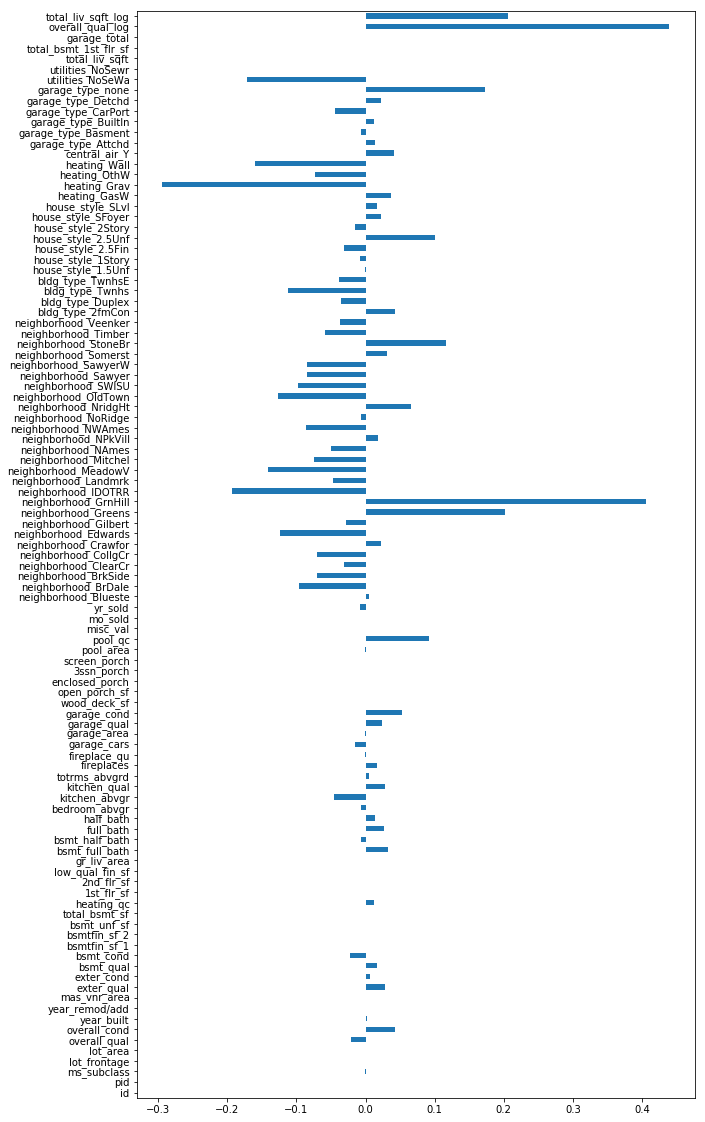

In [874]:
model_6.make_model(features_6,train_df_dummies_numeric)

In [875]:
test_df_dummies_numeric = pd.read_csv('../data/test_df_dummies_numeric.csv')

In [876]:
model_6.make_predicition_submission(test_df_dummies_numeric)

### Model 7
Using all features that have a correlation of more than 0.4 with saleprice_log. 
___

In [923]:
features_7_df = saleprice_log_corr_df[saleprice_log_corr_df['saleprice_log']>=0.4]

In [924]:
features_7_df.drop(index = 'saleprice', inplace = True)

/Users/kristina/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [925]:
features_7_df.drop(index = 'saleprice_log', inplace = True)

In [926]:
features_7 = features_7_df.index

In [927]:
features_7

Index(['total_liv_sqft_log', 'overall_qual', 'total_liv_sqft',
       'overall_qual_log', 'gr_liv_area', 'exter_qual', 'kitchen_qual',
       'garage_cars', 'garage_total', 'total_bsmt_sf', 'garage_area',
       'total_bsmt_1st_flr_sf', 'bsmt_qual', '1st_flr_sf', 'year_built',
       'year_remod/add', 'full_bath', 'fireplace_qu', 'heating_qc',
       'totrms_abvgrd', 'fireplaces', 'mas_vnr_area', 'bsmtfin_sf_1',
       'garage_type_Attchd'],
      dtype='object')

In [928]:
model_7 = CustomLinreg('model_7',7)

In [929]:
model_7.make_model(features_7)

         Train R2 score  Cross val R2 score  Test R2 score  Mean Squared Error
Model_7        0.881082            0.871384       0.893702            0.017377


In [930]:
test_df_dummies_model_7 = pd.read_csv("../data/test_df_dummies_model_7.csv")

In [931]:
model_7.make_OLS_params('OLS_model_7')

Parameters OLS 7: const                    3.824797e+00
total_liv_sqft_log       6.093685e-02
overall_qual            -3.136780e-02
total_liv_sqft           1.523637e-04
overall_qual_log         6.000198e-01
gr_liv_area             -7.115398e-05
exter_qual               2.550008e-02
kitchen_qual             3.805976e-02
garage_cars              1.785427e-02
garage_total             9.054167e-06
total_bsmt_sf           -6.799928e-05
garage_area              9.619268e-05
total_bsmt_1st_flr_sf   -1.832573e-08
bsmt_qual                1.268149e-02
1st_flr_sf               9.100386e-05
year_built               1.378854e-03
year_remod/add           1.544053e-03
full_bath               -1.954652e-02
fireplace_qu            -1.971407e-04
heating_qc               2.429007e-02
totrms_abvgrd            5.510713e-04
fireplaces               4.765714e-02
mas_vnr_area             6.373583e-06
bsmtfin_sf_1            -5.758560e-05
garage_type_Attchd       2.455064e-02
dtype: float64
-----------------

/Users/kristina/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [932]:
model_7.make_predicition_submission(test_df_dummies_model_2)

__Model 7 performed slightly better that Model 5 when evaluated against the test set.__

### Model 8
Using Ridge Regression.  
__Note:__ I did this before the lecture on regularization. I did not scale my data and because I am not using a lot of features, my model is most likly not overfit. I recognize now the way I performed the regularization doesn't make sense.
___

In [933]:

X_8 = train_df_dummies[features_7]
y_8 = train_df_dummies['saleprice_log']

    # train test split
X_8_train, X_8_test, y_8_train, y_8_test = train_test_split(X_8, y_8, 
                                                        random_state = 13)

rr = Ridge(alpha=0.01)
rr.fit(X_8_train, y_8_train) 
pred_train_rr= rr.predict(X_8_train)

print(r2_score(y_8_train, pred_train_rr))



0.8810821496048825


In [934]:
test_df_8 = test_df_dummies_model_2
test_preds_8 = rr.predict(test_df_8[features_7])
test_preds_invers_8 = np.exp(test_preds_8) #because sales price in the model is log
        

test_df_8['preds'] = test_preds_invers_8

submission_8 = test_df_8.loc[:, ['id', 'preds']]

submission_8.rename(columns = {'id': 'Id', 'preds': 'SalePrice'}, inplace=True)


submission_8.to_csv(f'../submissions/submission_8', index=False)

__Model 8 performed slightly better that Model 7 when evaluated against the test set.__

### Model 9
Using Lasso Regression on Features 7.  
__Note:__ I did this before the lecture on regularization. I did not scale my data and because I am not using a lot of features, my model is most likly not overfit. I recognize now the way I performed the regularization doesn't make sense.
___

In [935]:
X_9 = train_df_dummies[features_7]
y_9 = train_df_dummies['saleprice_log']

    # train test split
X_9_train, X_9_test, y_9_train, y_9_test = train_test_split(X_9, y_9, 
                                                        random_state = 13)

lr = Lasso(alpha=0.01)
lr.fit(X_9_train, y_9_train) 
pred_train_lr= lr.predict(X_9_train)


print(r2_score(y_9_train, pred_train_lr))


0.869326369638842


/Users/kristina/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 18.742209181982965, tolerance: 0.026193940622188206
  positive)


In [936]:
test_df_9 = test_df_dummies_model_2
test_preds_9 = lr.predict(test_df_9[features_7])
test_preds_invers_9 = np.exp(test_preds_9) #because sales price in the model is log
        

test_df_9['preds'] = test_preds_invers_9

submission_9 = test_df_9.loc[:, ['id', 'preds']]

submission_9.rename(columns = {'id': 'Id', 'preds': 'SalePrice'}, inplace=True)


submission_9.to_csv(f'../submissions/submission_9', index=False)

__Model 9 performed slightly worse that Model 8 when evaluated against the test set.__

### Model 10
Using Elastic Net Regression on Features 7.  
__Note:__ I did this before the lecture on regularization. I did not scale my data and because I am not using a lot of features, my model is most likly not overfit. I recognize now the way I performed the regularization doesn't make sense.
___

In [937]:
X_10 = train_df_dummies[features_7]
y_10 = train_df_dummies['saleprice_log']

    # train test split
X_10_train, X_10_test, y_10_train, y_10_test = train_test_split(X_10, y_10, 
                                                        random_state = 13)

enr = ElasticNet(alpha=0.01)
enr.fit(X_10_train, y_10_train) 
pred_train_enr= enr.predict(X_10_train)


print(r2_score(y_10_train, pred_train_enr))



0.8720369819210769


/Users/kristina/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 17.882864263121917, tolerance: 0.026193940622188206
  positive)


In [938]:
test_df_10 = test_df_dummies_model_2
test_preds_10 = enr.predict(test_df_10[features_7])
test_preds_invers_10 = np.exp(test_preds_10) #because sales price in the model is log
        

test_df_10['preds'] = test_preds_invers_10

submission_10 = test_df_10.loc[:, ['id', 'preds']]

submission_10.rename(columns = {'id': 'Id', 'preds': 'SalePrice'}, inplace=True)


submission_10.to_csv(f'../submissions/submission_10', index=False)

__Model 10 performed slightly worse that Model 8 when evaluated against the test set.__  
__Submission score: 23278.88821__

### Model 11
Using Lasso Regression on all numeric features. 
___

In [939]:
train_df_dummies_numeric = train_df_dummies.select_dtypes(include=[np.number])

In [940]:
train_df_dummies_numeric.drop(columns = 'saleprice', inplace = True)
train_df_dummies_numeric.drop(columns = 'saleprice_log', inplace = True)

/Users/kristina/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [941]:
test_df_dummies_numeric = pd.read_csv('../data/test_df_dummies_numeric.csv')

In [942]:
features_11 = train_df_dummies_numeric.columns

In [943]:
features_11

Index(['id', 'pid', 'ms_subclass', 'lot_frontage', 'lot_area', 'overall_qual',
       'overall_cond', 'year_built', 'year_remod/add', 'mas_vnr_area',
       ...
       'garage_type_CarPort', 'garage_type_Detchd', 'garage_type_none',
       'utilities_NoSeWa', 'utilities_NoSewr', 'total_liv_sqft',
       'total_bsmt_1st_flr_sf', 'garage_total', 'overall_qual_log',
       'total_liv_sqft_log'],
      dtype='object', length=103)

In [1012]:
model_11_lr = CustomLinreg('model_11_lr', 11)

In [1013]:
model_11_lr.make_sc(features_11, 'sc_model_11_lr', 'Z_test_model_11_lr', 'Z_train_model_11_lr', test_df_dummies_numeric)

          Train R2 score  Cross val R2 score  Test R2 score  \
Model_11        0.917852            0.901032       0.914756   

          Mean Squared Error  
Model_11            0.013935  


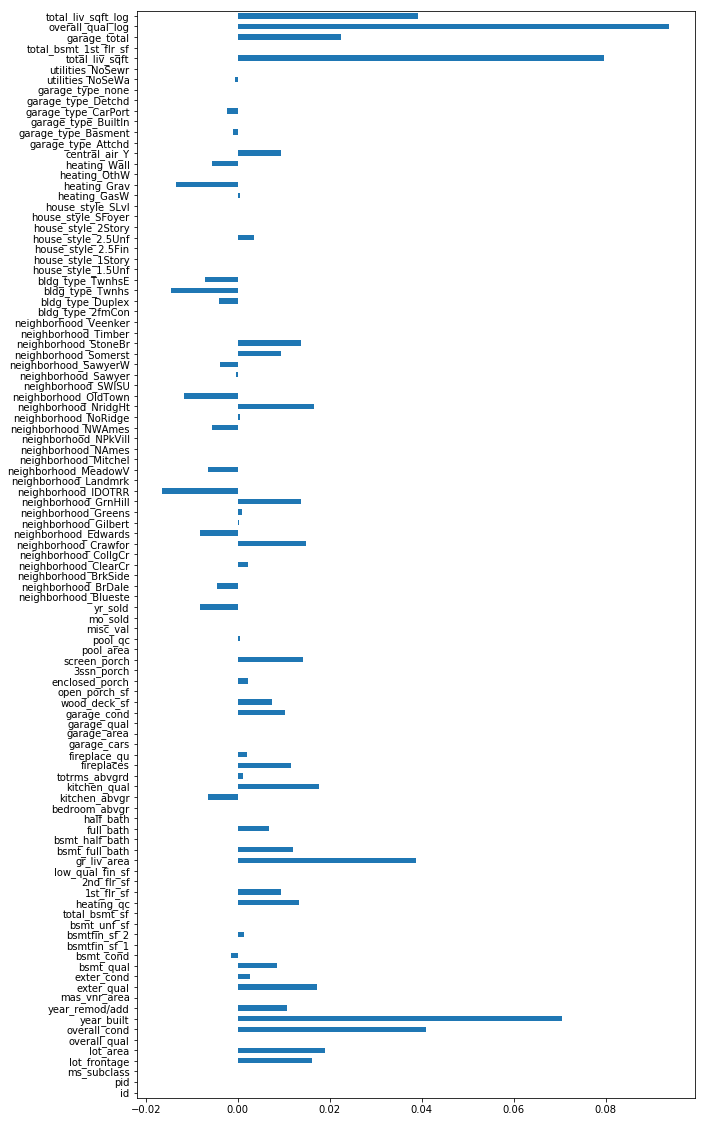

In [1014]:
model_11_lr.make_model_lasso()

In [1015]:
model_11_lr.make_predicition_submission_sc()

__Model 10 performed better that Model 8 when evaluated against the test set.__  
__Submission score: 20022.65587__

### Model 12
Using Ridge Regression on all numeric features from Model 11.
___

In [948]:
model_12_rr = CustomLinreg('model_12_rr', 12)

In [949]:
model_12_rr.make_sc(features_11, 'sc_model_12_rr', 'Z_test_model_12_rr', 'Z_train_model_12_rr', test_df_dummies_numeric)

          Train R2 score  Cross val R2 score  Test R2 score  \
Model_12        0.918336            0.901632       0.913093   

          Mean Squared Error  
Model_12            0.014207  


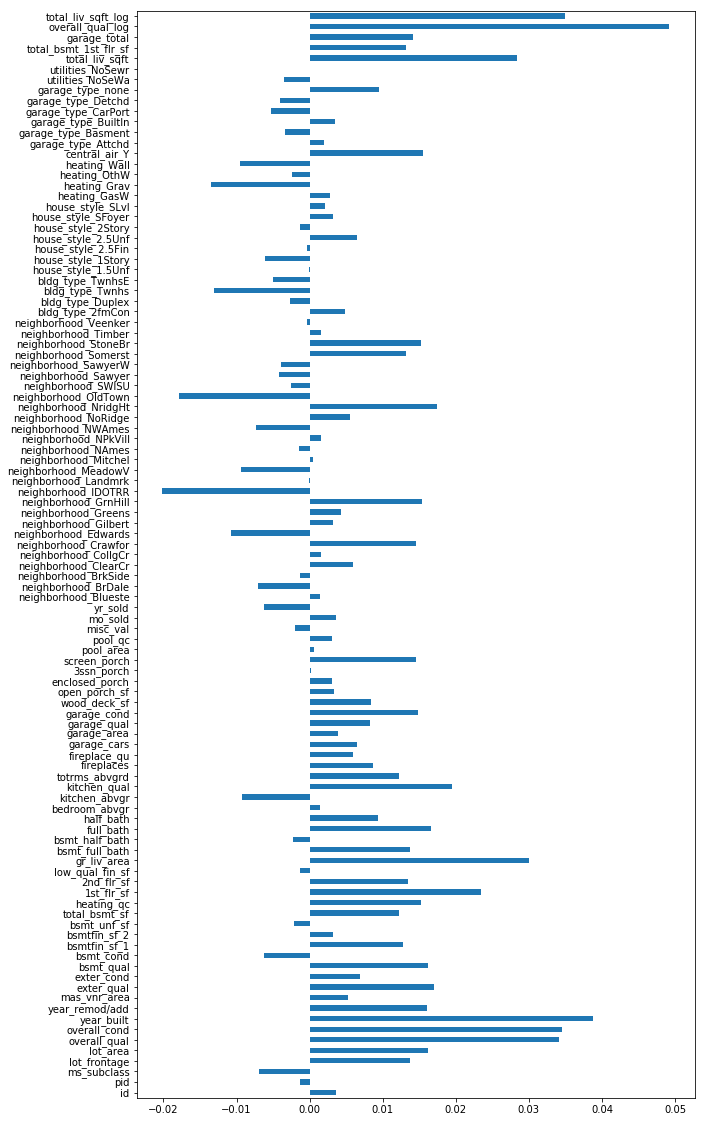

In [950]:
model_12_rr.make_model_ridge()

In [951]:
model_12_rr.make_predicition_submission_sc()

__Model 12 performed slightly better that Model 11 when evaluated against the test set.__  
__Submission score: 19567.64937.__  
__For submission I trained my model a second time on the whole train set and submitted the score of that. The error score decreased by 500 points.__

### Model 13
Using Elastic Net Regression on all numeric features from Model 11.
___

In [952]:
model_13_enr = CustomLinreg('model_13_enr', 13)

In [953]:
model_13_enr.make_sc(features_11, 'sc_model_13_enr', 'Z_test_model_13_enr', 'Z_train_model_13_enr', test_df_dummies_numeric)

          Train R2 score  Cross val R2 score  Test R2 score  \
Model_13         0.91799            0.901172       0.914818   

          Mean Squared Error  
Model_13            0.013925  


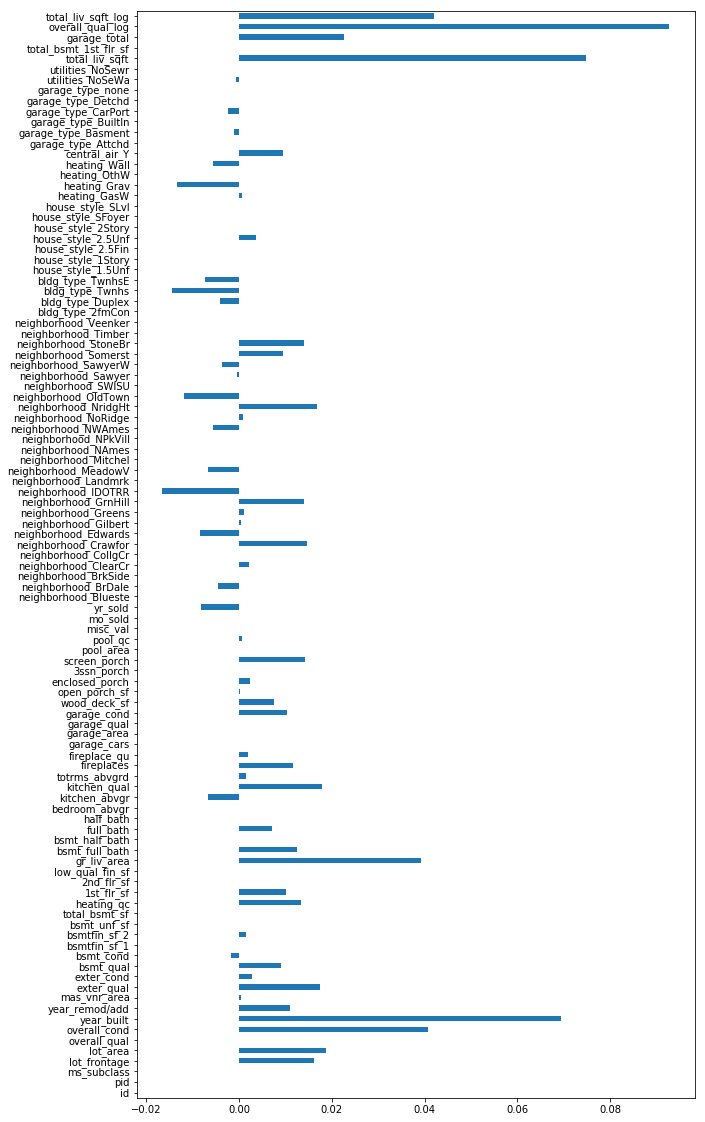

In [954]:
model_13_enr.make_model_elastic_net()

In [955]:
model_13_enr.make_predicition_submission_sc()

__Model 13 performed slightly worse that Model 12 when evaluated against the test set.__  
__Submission score: 19970.75318__

### Model 14
Using Lasso Regression on polynominal features from Model 4.
___

In [956]:
model_14 = CustomLinreg('model_14',14)

In [957]:
model_14.make_poly_features(features_4)

Use poly_df for Standardization


In [958]:
model_14.make_sc(features_4, 'model_14_sc', 'Z_test_model_14','Z_train_model_14', poly_df)

          Train R2 score  Cross val R2 score  Test R2 score  \
Model_14        0.869472            0.864763        0.88606   

          Mean Squared Error  
Model_14            0.018627  


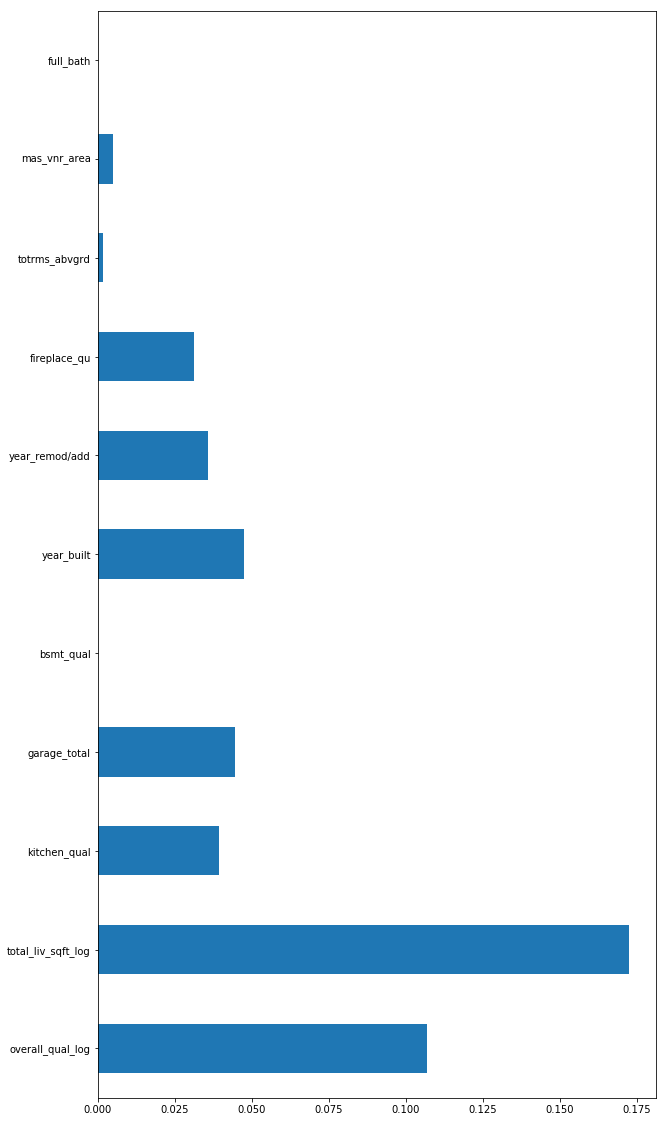

In [959]:
model_14.make_model_lasso()

In [960]:
poly_df['id'] = train_df_dummies['id']

In [961]:
model_14.make_predicition_submission_sc()

__I did not submit this model.__

### 4.4 Scores
___

#### 4.4.1 Import score DataFrames for every model

In [962]:
scores_11 = pd.read_csv("../data/model_evaluation_Model_11")

In [963]:
scores_12 = pd.read_csv("../data/model_evaluation_Model_12")

In [964]:
scores_13 = pd.read_csv("../data/model_evaluation_Model_13")

In [965]:
scores_1 = pd.read_csv("../data/model_evaluation_model_1")

In [966]:
scores_2 = pd.read_csv("../data/model_evaluation_model_2")

In [967]:
scores_3 = pd.read_csv("../data/model_evaluation_model_3")

In [968]:
scores_5 = pd.read_csv("../data/model_evaluation_model_5")

In [969]:
scores_7 = pd.read_csv("../data/model_evaluation_model_7")


In [970]:
scores_4 = pd.read_csv("../data/model_evaluation_model_4")

In [971]:
scores_14 = pd.read_csv("../data/model_evaluation_model_14")

In [983]:
scores_6 = pd.read_csv("../data/model_evaluation_model_6")

#### 4.4.2 Make and safe one score DataFrame for all models

In [1008]:
scores_pres = pd.concat([scores_11, scores_12, scores_13], axis = 0)

In [1009]:
scores_pres_index = [
                    'LASSO',
            'Ridge',
            'ElasticNet']

In [1010]:
scores_pres.index = scores_pres_index

In [1011]:
scores_pres

,Train R2 score,Cross val R2 score,Test R2 score,Mean Squared Error
LASSO,0.917852,0.901032,0.914756,0.013935
Ridge,0.918336,0.901632,0.913093,0.014207
ElasticNet,0.917990,0.901172,0.914818,0.013925


In [ ]:
'LASSO',
            'Ridge',
            'ElasticNet'

In [ ]:
scores_11, scores_12, scores_13

In [976]:
scores.index

Index(['Model 1', 'Model_2', 'Model_3', 'Model_4', 'Model_5', 'Model_7',
       'Model_11', 'Model_12', 'Model_13', 'Model_14'],
      dtype='object')

In [977]:
new_index = ['Model 1',
            'Model_2',
            'Model_3',
            'Model_4',
            'Model_5',
            'Model_7',
            'Model_11',
            'Model_12',
            'Model_13',
            'Model_14']

In [978]:
scores.index = new_index

In [979]:
scores

,Train R2 score,Cross val R2 score,Test R2 score,Mean Squared Error
Model 1,0.865167,0.863666,0.885843,0.018662
Model_2,0.869792,0.864925,0.886628,0.018534
Model_3,0.869559,0.865159,0.885696,0.018686
Model_4,0.869792,0.864925,0.886628,0.018534
Model_5,0.879156,0.870369,0.894068,0.017317
Model_7,0.881082,0.871384,0.893702,0.017377
Model_11,0.917852,0.901032,0.914756,0.013935
Model_12,0.918336,0.901632,0.913093,0.014207
Model_13,0.918920,0.907257,0.906910,0.004725
Model_14,0.869472,0.864763,0.886060,0.018627


In [980]:
scores.to_csv(r"../data/scores_total.csv", index=False)